In [12]:
# pip install torch torchvision torchaudio
# pip install tqdm

In [13]:
import os
import pickle

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import torch
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode 
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [50]:
df_train = pd.read_csv("./data/train.tsv", sep="\t")
df_dev = pd.read_csv("./data/dev.tsv", sep="\t")
df_test = pd.read_csv("./data/test.tsv", sep="\t")

df_train = df_train.drop_duplicates(subset=["tweet_text"])
df_dev = df_dev.drop_duplicates(subset=["tweet_text"])
df_test = df_test.drop_duplicates(subset=["tweet_text"])

df_train["label_text"] = df_train["label_text"].apply(lambda s: 1 if s == "informative" else 0)
df_dev["label_text"] = df_dev["label_text"].apply(lambda s: 1 if s == "informative" else 0)
df_test["label_text"] = df_test["label_text"].apply(lambda s: 1 if s == "informative" else 0)


In [65]:
df_dev["label_text"]


0       1
1       1
2       1
3       1
4       1
       ..
2232    0
2233    1
2234    0
2235    0
2236    1
Name: label_text, Length: 2237, dtype: int64

In [52]:
def print_metrics(model, X, y):
    """Prints performance metrics"""
    y_pred = model.predict(X) # Predicted labels
    y_pred_proba = model.predict_proba(X) # Predicted probabilities
    
    # Test accuracy
    print(f"Accuracy: {metrics.accuracy_score(y_true=y, y_pred=y_pred)}\n")
    
    # Classification report
    print(metrics.classification_report(y_true=y, y_pred=y_pred))

    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    # Confusion matrix
    cm = metrics.confusion_matrix(y_true=y, y_pred=y_pred)
    sns.heatmap(cm, annot=True, fmt="d", ax=ax1, cmap=plt.cm.Blues, cbar=False)
    ax1.set(
        xlabel="Pred", ylabel="True", 
        xticklabels=[0, 1], yticklabels=[0, 1], 
        title="Confusion Matrix"
    )

    # ROC curve/AUC score
    fpr, tpr, thresholds = metrics.roc_curve(
        y_true=y, y_score=y_pred_proba[:, 1], pos_label=1
    )
    auc_score = metrics.roc_auc_score(y_true=y, y_score=y_pred_proba[:, 1])
    ax2.plot(
        fpr, tpr, color="red", label=f"ROC Curve (AUC = {round(auc_score, 3)})"
    )
    ax2.set_xlabel("False Positive Rate")
    ax2.set_ylabel("True Positive Rate")
    ax2.set_title("ROC Curve")
    ax2.legend(loc="best")

In [22]:
pip install -U sentence-transformers

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 15.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 10.1 MB/s eta 0:00:00 0:00:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 16.3 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.7/311.7 kB 13.7 MB/s eta 0:00:00
  Using cached PyYAML-6.0.1-cp311-cp311-macosx_11_0_arm64.whl (167 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 291.0/291.0 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 12.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.3/426.3 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.9/97.9 kB 11.1 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=

In [53]:
from sentence_transformers import SentenceTransformer
from tqdm import tqdm
import torch

model = SentenceTransformer('all-MiniLM-L6-v2')

train_embeddings = []
batch_size = 64

for i in tqdm(range(0, len(df_train), batch_size)):
    text_batch = df_train["tweet_text"][i: i + batch_size].apply(lambda s: s[:77]).tolist()

    with torch.no_grad():
        text_batch_features = model.encode(text_batch)

    train_embeddings.extend(text_batch_features)


100%|██████████| 181/181 [00:41<00:00,  4.32it/s]


In [54]:
with open("sent_bert_train_embeddings.pkl", mode="wb") as f:
    pickle.dump(train_embeddings, f)

In [92]:
dev_embeddings = []
batch_size = 64

for i in tqdm(range(0, len(df_dev), batch_size)):
    text_batch = df_dev["tweet_text"][i : i + batch_size].apply(lambda s: s[:77]).tolist()

    with torch.no_grad():
        text_batch_features = model.encode(text_batch)

    dev_embeddings.extend(text_batch_features)


100%|██████████| 35/35 [00:08<00:00,  4.26it/s]


In [93]:
with open("sent_bert_dev_embeddings.pkl", mode="wb") as f:
    pickle.dump(dev_embeddings, f)

In [97]:
with open("sent_bert_train_embeddings.pkl", mode="rb") as f:
    train_embeddings = pickle.load(f)

with open("sent_bert_dev_embeddings.pkl", mode="rb") as f:
    dev_embeddings = pickle.load(f)

Accuracy: 0.8240676795580111

              precision    recall  f1-score   support

           0       0.75      0.57      0.65      3299
           1       0.84      0.92      0.88      8285

    accuracy                           0.82     11584
   macro avg       0.80      0.75      0.77     11584
weighted avg       0.82      0.82      0.82     11584



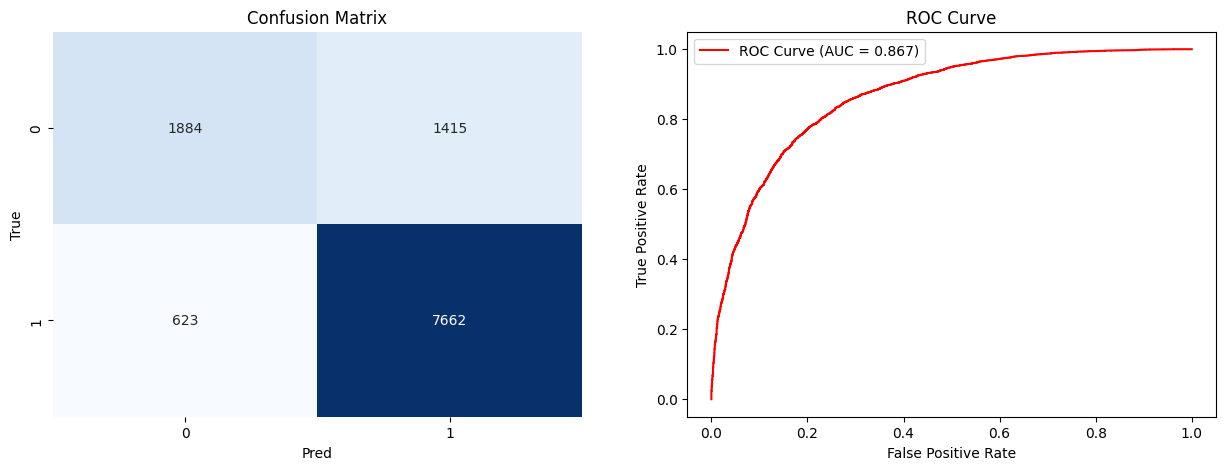

In [98]:
clf = LogisticRegression(random_state=42)
clf.fit(train_embeddings, df_train["label_text"])
print_metrics(clf, train_embeddings, df_train["label_text"])

Accuracy: 0.813589628967367

              precision    recall  f1-score   support

           0       0.72      0.55      0.62       625
           1       0.84      0.92      0.88      1612

    accuracy                           0.81      2237
   macro avg       0.78      0.73      0.75      2237
weighted avg       0.81      0.81      0.80      2237



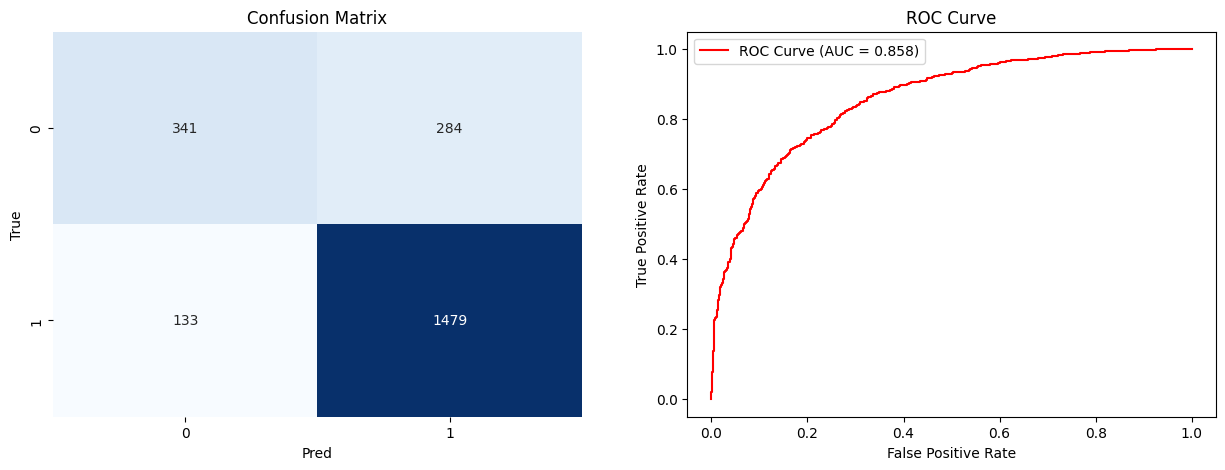

In [96]:
print_metrics(clf, dev_embeddings, df_dev["label_text"])